In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq self-supervised

In [ ]:
#default_exp vision.supcon

# SupCon

> **SupCon**: [Supervised Contrastive Learning](https://arxiv.org/pdf/2004.11362.pdf)

In [ ]:
#export
_all_ = ['UnsupMethod']

In [ ]:
#export
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

## Algorithm

#### SupCon

![SupCon Framework](images/supcon.png)

SupCon introduces a generalized form for contrastive losses, and shows that self-supervised loss from SimCLR, N-Pair loss and triplet margin loss are special cases. In this repo, we leverage this general form and formalize a loss that can transition from self-supervised contrastive loss to supervised contrastive loss:

$$
\begin{equation} 
\begin{split}
\mathcal{L} & = \hspace{30mm} \mathcal{L}^{unsup} \hspace{16mm}+ \hspace{30mm} \lambda\mathcal{L}^{sup} \\
            \\
            & = - \sum_{i \in I} \log \frac{\exp \left(\boldsymbol{z}_{i} \cdot \boldsymbol{z}_{j(i)} / \tau\right)}{\sum_{a \in A(i)} \exp \left(\boldsymbol{z}_{i} \cdot \boldsymbol{z}_{a} / \tau\right)} + \lambda \sum_{i \in I} \frac{-1}{|P(i)|} \sum_{p \in P(i)} \log \frac{\exp \left(\boldsymbol{z}_{i} \cdot \boldsymbol{z}_{p} / \tau\right)}{\sum_{a \in A(i)} \exp \left(\boldsymbol{z}_{i} \cdot \boldsymbol{z}_{a} / \tau\right)}
\end{split}
\end{equation}
$$


We use supervised signal as regularization which has an associated weight $\lambda$, this allows to pretrain with a dataset mixed with labelled and unlabelled data. This regularization can help to learn more generic features which in turn can help with the downstream task. In `SupCon` callback you can choose to use all samples (`UnsupMethod.All`) for unsupervised loss or only use the ones doesn't have a label (`UnsupMethod.All`). Supervised loss will use the samples with labels.

Therefore, positive samples come form two disjoint categories:
    
    (1) Other view of the anchor sample after augmentation (self-supervised case)
    (2) All views of the samples that have the same class id with anchor, including the other view of the same sample (supervised case)
    
    
    
*Note that self-supervised and unsupervised are used interchangably in this context*

SimCLR model consists of an `encoder` and a `projector (MLP)` layer. The definition of this module is fairly simple as below.

In [ ]:
#export
class SupConModel(Module):
    "Compute predictions of concatenated xi and xj" 
    def __init__(self,encoder,projector): self.encoder,self.projector = encoder,projector
    def forward(self,x): return self.projector(self.encoder(x))

Instead of directly using `SupConModel` by passing both an `encoder` and a `projector`, `create_simclr_model` function can be used by minimally passing a predefined `encoder` and the expected input channels.

In [ ]:
#export
def create_supcon_model(encoder, hidden_size=256, projection_size=128, bn=False, nlayers=2):
    "Create SupCon model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return SupConModel(encoder, projector)

You can use `self_supervised.layers` module to create an encoder. It supports all **timm** and **fastai** models available out of the box.

We define number of input channels with `n_in`, projector/mlp's hidden size with `hidden_size`,  projector/mlp's final projection size with `projection_size` and projector/mlp's number of layers with `nlayers`.

In [ ]:
encoder = create_encoder("tf_efficientnet_b0_ns", n_in=3, pretrained=False, pool_type=PoolingType.CatAvgMax)
model = create_supcon_model(encoder, hidden_size=2048, projection_size=128, nlayers=2)
out = model(torch.randn((2,3,224,224))); out.shape

torch.Size([2, 128])

## SupCon Callback

The following parameters can be passed;

- **aug_pipelines** list of augmentation pipelines List[Pipeline] created using functions from `self_supervised.augmentations` module. Each `Pipeline` should be set to `split_idx=0`. You can simply use `get_supcon_aug_pipelines` utility to get aug_pipelines.
- **temp** temperature scaling for cross entropy loss (defaults to paper's best value)

SupCon algorithm uses 2 views of a given image, and `SupCon` callback expects a list of 2 augmentation pipelines in `aug_pipelines`.

You can simply use helper function `get_supcon_aug_pipelines()` which will allow augmentation related arguments such as size, rotate, jitter...and will return a list of 2 pipelines, which then can be passed to the callback. This function uses `get_multi_aug_pipelines` which then `get_batch_augs`. For more information you may refer to `self_supervised.augmentations` module.

Also, you may choose to pass your own list of aug_pipelines which needs to be List[Pipeline, Pipeline] where Pipeline(..., split_idx=0). Here, `split_idx=0` forces augmentations to be applied in training mode.

In [ ]:
#export
@delegates(get_multi_aug_pipelines)
def get_supcon_aug_pipelines(size, **kwargs): return get_multi_aug_pipelines(n=2, size=size, **kwargs)

In [ ]:
aug_pipelines = get_supcon_aug_pipelines(size=28, rotate=False, jitter=False, bw=False, blur=False, stats=None, cuda=False)
aug_pipelines

[Pipeline: RandomResizedCrop -> RandomHorizontalFlip,
 Pipeline: RandomResizedCrop -> RandomHorizontalFlip]

In [ ]:
#export
mk_class('UnsupMethod', **{o:o.lower() for o in ['All', 'Only']},
         doc="Whether to use all (sup+unsup) or only unsup data in a batch for unsup loss") 

In [ ]:
#export
class SupCon(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, unsup_class_id, unsup_method=UnsupMethod.All, 
                 reg_lambda=1.,
                 temp=0.07, 
                 print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('unsup_class_id,unsup_method,reg_lambda,temp')
        
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
                    
            
    def before_batch(self):
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)
    
    
    def _remove_diag(self, x):
        bs = x.shape[0]
        return x[~torch.eye(bs).bool()].reshape(bs,bs-1)    
    
    
    def unsup_lf(self, pred, yb):
        "Self-Supervised contrasitve loss with all or only unlabelled batch samples"
        targ = torch.cat([yb,yb])
        unsup_mask = (targ == self.unsup_class_id)
        if self.unsup_method == UnsupMethod.All:
            pass
        elif self.unsup_method == UnsupMethod.Only:
            pred = pred[unsup_mask]
        else:
            raise Exception(f"{self.unsup_method} is not a valid UnsupMethod")
        
        if len(pred) == 0: return 0
        
        pred = F.normalize(pred, dim=1)
        bs = pred.shape[0]
        targ = torch.arange(bs, device=pred.device).roll(bs//2)
        sim  = self._remove_diag(pred @ pred.T) / self.temp
        targ = self._remove_diag(torch.eye(targ.shape[0], device=pred.device)[targ]).nonzero()[:,-1]
        return F.cross_entropy(sim, targ)
        
        
    def sup_lf(self, pred, yb):
        "Supervised contrasitve loss with labelled batch samples"
        targ = torch.cat([yb,yb])
        unsup_mask = (targ == self.unsup_class_id)
        pred = pred[~unsup_mask]
        targ = targ[~unsup_mask]
        
        if len(pred) == 0: return 0
        
        # exclude anchor from loss calc
        ohe_labels = (targ[...,None] == targ[None, ...]).float()
        pred = F.normalize(pred, dim=1)
        sim  = self._remove_diag(pred @ pred.T) / self.temp
        targ = self._remove_diag(ohe_labels)

        return (F.cross_entropy(sim, targ, reduction='none')/targ.sum(1)).mean()
        
    
    def lf(self, pred, *yb):
        unsup_loss = self.unsup_lf(pred, *yb)
        sup_loss   = self.sup_lf(pred, *yb)
        return unsup_loss + self.reg_lambda*sup_loss
    
    
    @torch.no_grad()
    def show(self, n=1):
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:] 
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

### Tests

In [ ]:
# No unsupervised, all samples are labelled, but use all for unsup loss
supcon = SupCon([Pipeline([],0),Pipeline([],0)], unsup_class_id=0, unsup_method="all")
yb = torch.tensor([1,1,2,2])
pred = torch.randn((yb.shape[0]*2,128))

In [ ]:
loss1 = supcon.unsup_lf(pred, yb)
nll = -(supcon._remove_diag(F.normalize(pred) @ F.normalize(pred).T)/supcon.temp).log_softmax(1)
loss2 = torch.mean(tensor([nll[i,idx] for i, idx in enumerate([3,4,5,6,0,1,2,3])]))
assert torch.isclose(loss1,loss2)

In [ ]:
loss1 = supcon.sup_lf(pred, yb)
nll = -(supcon._remove_diag(F.normalize(pred) @ F.normalize(pred).T)/supcon.temp).log_softmax(1)
ohe = supcon._remove_diag(tensor([[1,1,0,0,1,1,0,0],
                                 [1,1,0,0,1,1,0,0],
                                 [0,0,1,1,0,0,1,1],
                                 [0,0,1,1,0,0,1,1],
                                 [1,1,0,0,1,1,0,0],
                                 [1,1,0,0,1,1,0,0],
                                 [0,0,1,1,0,0,1,1],
                                 [0,0,1,1,0,0,1,1]]))
loss2 = (tensor([(row[idxs.bool()].sum()/idxs.sum()) for row, idxs in zip(nll, ohe)])).mean()
assert torch.isclose(loss1, loss2)

In [ ]:
# No unsupervised, all samples are labelled, use only unlabelled for unsup loss
supcon = SupCon([Pipeline([],0),Pipeline([],0)], unsup_class_id=0, unsup_method="only")
yb = torch.tensor([1,1,2,2])
pred = torch.randn((yb.shape[0]*2,128))

In [ ]:
loss1 = supcon.unsup_lf(pred, yb)
assert loss1 == 0

In [ ]:
loss1 = supcon.sup_lf(pred, yb)
nll = -(supcon._remove_diag(F.normalize(pred) @ F.normalize(pred).T)/supcon.temp).log_softmax(1)
ohe = supcon._remove_diag(tensor([[1,1,0,0,1,1,0,0],
                                 [1,1,0,0,1,1,0,0],
                                 [0,0,1,1,0,0,1,1],
                                 [0,0,1,1,0,0,1,1],
                                 [1,1,0,0,1,1,0,0],
                                 [1,1,0,0,1,1,0,0],
                                 [0,0,1,1,0,0,1,1],
                                 [0,0,1,1,0,0,1,1]]))
loss2 = (tensor([(row[idxs.bool()].sum()/idxs.sum()) for row, idxs in zip(nll, ohe)])).mean()
assert torch.isclose(loss1,loss2)

In [ ]:
# All samples are unlabelled, but use all for unsup loss
yb = torch.tensor([0,0,0,0])
pred = torch.randn((yb.shape[0]*2,128))

In [ ]:
supcon = SupCon([Pipeline([],0),Pipeline([],0)], unsup_class_id=0, unsup_method="all")
loss1 = supcon.unsup_lf(pred, yb)
supcon = SupCon([Pipeline([],0),Pipeline([],0)], unsup_class_id=0, unsup_method="only")
loss2 = supcon.unsup_lf(pred, yb)
nll = -(supcon._remove_diag(F.normalize(pred) @ F.normalize(pred).T)/supcon.temp).log_softmax(1)
loss3 = torch.mean(tensor([nll[i,idx] for i, idx in enumerate([3,4,5,6,0,1,2,3])]))
assert torch.isclose(loss1, loss2) and torch.isclose(loss2, loss3)

In [ ]:
loss1 = supcon.sup_lf(pred, yb)
assert loss1 == 0

In [ ]:
# Mixed samples, but use all for unsup loss
yb = torch.tensor([1,1,2,0])
pred = torch.randn((yb.shape[0]*2,128))
supcon = SupCon([Pipeline([],0),Pipeline([],0)], unsup_class_id=0, unsup_method="all")

In [ ]:
loss1 = supcon.unsup_lf(pred, yb)
nll = -(supcon._remove_diag(F.normalize(pred) @ F.normalize(pred).T)/supcon.temp).log_softmax(1)
loss2 = torch.mean(tensor([nll[i,idx] for i, idx in enumerate([3,4,5,6,0,1,2,3])]))
assert torch.isclose(loss1, loss2)

In [ ]:
supcon = SupCon([Pipeline([],0),Pipeline([],0)], unsup_class_id=0, unsup_method="only")
loss1 = supcon.unsup_lf(pred, yb)
assert loss1 == 0 # log(1) -> 0, there is no negative sample

In [ ]:
loss1 = supcon.sup_lf(pred, yb)
targ = torch.cat([yb,yb])
unsup_mask = (targ == supcon.unsup_class_id)
pred = pred[~unsup_mask]
nll = -(supcon._remove_diag(F.normalize(pred) @ F.normalize(pred).T)/supcon.temp).log_softmax(1)
ohe = supcon._remove_diag(tensor([[1,1,0,1,1,0],
                                  [1,1,0,1,1,0],
                                  [0,0,1,0,0,1],
                                  [1,1,0,1,1,0],
                                  [1,1,0,1,1,0],
                                  [0,0,1,0,0,1]]))

loss2 = (tensor([(row[idxs.bool()].sum()/idxs.sum()) for row, idxs in zip(nll, ohe)])).mean()
assert torch.isclose(loss1, loss2)

## SupConMOCO Callback [Experimental]

The following parameters can be passed;

- **aug_pipelines** list of augmentation pipelines List[Pipeline] created using functions from `self_supervised.augmentations` module. Each `Pipeline` should be set to `split_idx=0`. You can simply use `get_supcon_aug_pipelines` utility to get aug_pipelines.
- **temp** temperature scaling for cross entropy loss (defaults to paper's best value)

SupCon algorithm uses 2 views of a given image, and `SupCon` callback expects a list of 2 augmentation pipelines in `aug_pipelines`.

You can simply use helper function `get_supcon_aug_pipelines()` which will allow augmentation related arguments such as size, rotate, jitter...and will return a list of 2 pipelines, which then can be passed to the callback. This function uses `get_multi_aug_pipelines` which then `get_batch_augs`. For more information you may refer to `self_supervised.augmentations` module.

Also, you may choose to pass your own list of aug_pipelines which needs to be List[Pipeline, Pipeline] where Pipeline(..., split_idx=0). Here, `split_idx=0` forces augmentations to be applied in training mode.

In [ ]:
#export
class SupConMOCO(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, unsup_class_id, unsup_method=UnsupMethod.All, 
                 K=4096,
                 m=0.999,
                 reg_lambda=1.,
                 temp=0.07, 
                 print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('unsup_class_id,unsup_method,K,m,reg_lambda,temp')
        
        
    def before_fit(self): 
        "Create key encoder and init queue"
        if (not hasattr(self, "encoder_k")) and (not hasattr(self, "queue")):
            # init key encoder
            self.encoder_k = deepcopy(self.learn.model).to(self.dls.device)
            for param_k in self.encoder_k.parameters(): param_k.requires_grad = False
            
            # init queue
            nf = self.learn.model.projector[-1].out_features
            self.emb_queue = torch.randn(self.K, nf).to(self.dls.device)
            self.emb_queue = nn.functional.normalize(self.emb_queue, dim=1)
            self.label_queue = torch.zeros(self.K).to(self.dls.device) + self.unsup_class_id
            self.queue_ptr = 0
        else: 
            warnings.warn("Key encoder and queue are already defined, keeping them.")
        
        self.learn.loss_func = self.lf
                    
    
    def before_batch(self):
        "Generate query and key for the current batch"
        q_img,k_img = self.aug1(self.x), self.aug2(self.x.clone())
        self.learn.xb = (q_img,)
        with torch.no_grad(): 
            self.encoder_k.eval()
            self.learn.yb = (F.normalize(self.encoder_k(k_img)), self.y) # query and labels
    
    
    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for param_q, param_k in zip(self.learn.model.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)
        
        
    @torch.no_grad()
    def _dequeue_and_enqueue(self):
        bs = self.x.size(0)
        key_embs, key_labels = self.yb
        assert self.K % bs == 0  # for simplicity
        self.emb_queue[self.queue_ptr:self.queue_ptr+bs, :] = key_embs
        self.label_queue[self.queue_ptr:self.queue_ptr+bs] = key_labels
        self.queue_ptr = (self.queue_ptr + bs) % self.K  # move pointer

        
    def unsup_lf(self, pred, key_embs, key_labels):
        "Self-Supervised contrasitve loss with all or only unlabelled batch samples"
        query_embs = F.normalize(pred, dim=1)        
        queue_embs, queue_labels = self.emb_queue, self.label_queue
        
        if self.unsup_method == UnsupMethod.All:
            key_embs = torch.cat([key_embs, queue_embs])
        
        elif self.unsup_method == UnsupMethod.Only:
            query_embs = query_embs[(key_labels == self.unsup_class_id)]
            key_embs   = key_embs[(key_labels == self.unsup_class_id)]
            queue_embs = queue_embs[(queue_labels == self.unsup_class_id)]
            
            key_embs   = torch.cat([key_embs, queue_embs])
                        
        else:
            raise Exception(f"{self.unsup_method} is not a valid UnsupMethod")
        
        if len(query_embs) == 0: return 0
        
        labels = torch.arange(len(query_embs), device=pred.device)
        sim  = query_embs @ key_embs.T / self.temp
        return F.cross_entropy(sim, labels)
        
        
    def sup_lf(self, pred, key_embs, key_labels):
        "Supervised contrasitve loss with labelled batch samples"
        query_embs = F.normalize(pred, dim=1)
        queue_embs, queue_labels = self.emb_queue,  self.label_queue
        
        query_embs = query_embs[(key_labels != self.unsup_class_id)]
        key_embs   = key_embs[(key_labels != self.unsup_class_id)]
        queue_embs = queue_embs[(queue_labels != self.unsup_class_id)]
        
        key_embs   = torch.cat([key_embs, queue_embs])
        
        key_labels   = key_labels[(key_labels != self.unsup_class_id)]
        queue_labels = queue_labels[(queue_labels != self.unsup_class_id)]
        
        labels   = torch.cat([key_labels, queue_labels])
        
        if len(query_embs) == 0: return 0
            
        # exclude anchor from loss calc
        ohe_labels = (key_labels[...,None] == labels[None, ...]).float()
        sim  = query_embs @ key_embs.T / self.temp
        return (F.cross_entropy(sim, ohe_labels, reduction='none')/ohe_labels.sum(1)).mean()
        
    
    def lf(self, pred, *yb):
        unsup_loss = self.unsup_lf(pred, *yb)
        sup_loss   = self.sup_lf(pred, *yb)
        return unsup_loss + self.reg_lambda*sup_loss
    
    
    def after_step(self):
        "Update momentum (key) encoder and queue"
        self._momentum_update_key_encoder()
        self._dequeue_and_enqueue()
    
    
    @torch.no_grad()
    def show(self, n=1):
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:] 
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

### Tests

In [ ]:
from fastai.test_utils import *

In [ ]:
class ContrastiveModel(Module):
    def __init__(self): 
        self.encoder   = nn.Parameter(tensor([1.]))
        self.projector = nn.Linear(1,5, bias=False)
        self.projector.weight.data.zero_()
        self.projector.weight.data += 1
        self.projector = nn.Sequential(self.projector)
        
    def forward(self, x): return self.projector(x*self.encoder)

In [ ]:
# No unsupervised, all samples are labelled, but use all for unsup loss
supcon = SupConMOCO([Pipeline([noop],0),Pipeline([noop],0)], unsup_class_id=0, unsup_method="all", K=8, m=0.999, reg_lambda=1.0, temp=0.07)
yb = torch.tensor([1,1,2,2])
pred = torch.randn((yb.shape[0]*2,128))

In [ ]:
learner = synth_learner(cbs=supcon, data=synth_dbunch(a=0,b=0,bs=4), model=ContrastiveModel())

In [ ]:
learner.sup_con_moco.aug1, learner.sup_con_moco.aug2

(Pipeline: , Pipeline: )

In [ ]:
learner.sup_con_moco.__dict__['__stored_args__']

{'unsup_class_id': 0,
 'unsup_method': 'all',
 'K': 8,
 'm': 0.999,
 'reg_lambda': 1.0,
 'temp': 0.07}

In [ ]:
learner('before_fit')

In [ ]:
assert learner.sup_con_moco.emb_queue.shape == (8,5)
assert torch.all(learner.sup_con_moco.label_queue == torch.zeros(8))
assert not any(list(o.requires_grad for o in learner.sup_con_moco.encoder_k.parameters()))
assert torch.all(learner.sup_con_moco.encoder_k.projector[0].weight == 1)

In [ ]:
b = tensor([1,1,-1,1]).reshape(-1,1),tensor([1,1,2,2])
learner._split(b)
learner('before_batch')

In [ ]:
key_embs, labels = learner.sup_con_moco.yb
assert torch.equal(F.normalize(learner.sup_con_moco.encoder_k(b[0])), key_embs)
assert torch.equal(labels, b[1])

In [ ]:
learner.model.encoder.data += 0.1 # pseudo param update 1.0 -> 1.1
learner.model.projector[0].weight.data += 0.1 # pseudo param update 1.0 -> 1.1

In [ ]:
learner('after_step')

In [ ]:
assert torch.equal(learner.sup_con_moco.emb_queue[:4], key_embs)

In [ ]:
newval = 1*supcon.m + 1.1*(1-supcon.m)
assert torch.all(learner.sup_con_moco.encoder_k.encoder.data == newval) and torch.all(learner.sup_con_moco.encoder_k.projector[0].weight.data==newval)

In [ ]:
b = tensor([-1,-1,1,-1]).reshape(-1,1),tensor([1,1,2,2])
learner._split(b)
learner('before_batch')

In [ ]:
key_embs, labels = learner.sup_con_moco.yb
assert torch.equal(F.normalize(learner.sup_con_moco.encoder_k(b[0])), key_embs)
assert torch.equal(labels, b[1])

In [ ]:
learner('after_step')

In [ ]:
assert torch.equal(learner.sup_con_moco.emb_queue[-4:], key_embs)
assert torch.equal(learner.sup_con_moco.label_queue, tensor([1,1,2,2,1,1,2,2]).float())

In [ ]:
newval = newval*supcon.m + 1.1*(1-supcon.m)
assert torch.all(learner.sup_con_moco.encoder_k.encoder.data == newval) and torch.all(learner.sup_con_moco.encoder_k.projector[0].weight.data==newval)

In [ ]:
pred = F.normalize(learner.model(learner.x))
loss1 = learner.sup_con_moco.unsup_lf(pred, *learner.yb)
key_embs, labels = learner.yb
logits = pred @ torch.cat([key_embs,learner.sup_con_moco.emb_queue]).T / learner.sup_con_moco.temp
loss2 = F.cross_entropy(logits, tensor([0,1,2,3]))
assert loss1 == loss2

In [ ]:
learner.sup_con_moco.unsup_method = UnsupMethod.Only
learner.sup_con_moco.unsup_class_id = 1
loss1 = learner.sup_con_moco.unsup_lf(pred, *learner.yb)
logits = pred[labels==1] @ torch.cat([key_embs[labels==1],learner.sup_con_moco.emb_queue[learner.sup_con_moco.label_queue==1]]).T / learner.sup_con_moco.temp
loss2 = F.cross_entropy(logits, tensor([0,1]))
assert loss1 == loss2

In [ ]:
learner.sup_con_moco.unsup_class_id = 0
pred = F.normalize(learner.model(learner.x))
loss1 = learner.sup_con_moco.sup_lf(pred, *learner.yb)
logits = pred @ torch.cat([key_embs,learner.sup_con_moco.emb_queue]).T / learner.sup_con_moco.temp
ohe_labels = tensor([[1., 1., 0, 0, 1., 1., 0, 0, 1., 1., 0, 0],
                     [1., 1., 0, 0, 1., 1., 0, 0, 1., 1., 0, 0],
                     [0,  0,  1, 1, 0,  0,  1, 1, 0,  0,  1, 1,],
                     [0,  0,  1, 1, 0,  0,  1, 1, 0,  0,  1, 1]])
loss2 = (F.cross_entropy(logits, ohe_labels, reduction='none') / ohe_labels.sum(1)).mean()
assert loss1 == loss2

In [ ]:
learner.sup_con_moco.unsup_class_id = 2
pred = F.normalize(learner.model(learner.x))
loss1 = learner.sup_con_moco.sup_lf(pred, *learner.yb)
logits = pred[labels != 2] @ torch.cat([key_embs[labels != 2],learner.sup_con_moco.emb_queue[learner.sup_con_moco.label_queue != 2]]).T / learner.sup_con_moco.temp
ohe_labels = tensor([[1., 1., 1., 1., 1., 1.],
                     [1., 1., 1., 1., 1., 1.]])
loss2 = (F.cross_entropy(logits, ohe_labels, reduction='none') / ohe_labels.sum(1)).mean()
assert loss1 == loss2

In [ ]:
key_embs, labels = learner.yb
learner.sup_con_moco.unsup_class_id = 3
learner.xb = (torch.cat([learner.x, tensor([[0]])]),)
key_embs, labels = torch.cat([learner.y[0], learner.y[0][:1]]), torch.cat([learner.y[1],  tensor([3])])
learner.yb = (key_embs, labels)
pred = F.normalize(learner.model(learner.x))
loss1 = learner.sup_con_moco.sup_lf(pred, *learner.yb)
logits = pred[labels != 3] @ torch.cat([key_embs[labels != 3],learner.sup_con_moco.emb_queue[learner.sup_con_moco.label_queue != 3]]).T / learner.sup_con_moco.temp
ohe_labels = tensor([[1., 1., 0, 0, 1., 1., 0, 0, 1., 1., 0, 0],
                     [1., 1., 0, 0, 1., 1., 0, 0, 1., 1., 0, 0],
                     [0,  0,  1, 1, 0,  0,  1, 1, 0,  0,  1, 1,],
                     [0,  0,  1, 1, 0,  0,  1, 1, 0,  0,  1, 1]])
loss2 = (F.cross_entropy(logits, ohe_labels, reduction='none') / ohe_labels.sum(1)).mean()
assert loss1 == loss2

In [ ]:
key_embs, labels = learner.yb
learner.sup_con_moco.unsup_class_id = 3

learner.xb = (torch.cat([learner.x[:2],tensor([[0]]), learner.x[2:]]),)
key_embs, labels = torch.cat([learner.y[0][:2], learner.y[0][:1], learner.y[0][2:]]), torch.cat([learner.y[1][:2],  tensor([3]), learner.y[1][2:]])

learner.yb = (key_embs, labels)
pred = F.normalize(learner.model(learner.x))

loss1 = learner.sup_con_moco.sup_lf(pred, *learner.yb)
logits = pred[labels != 3] @ torch.cat([key_embs[labels != 3],learner.sup_con_moco.emb_queue[learner.sup_con_moco.label_queue != 3]]).T / learner.sup_con_moco.temp
ohe_labels = tensor([[1., 1., 0, 0, 1., 1., 0, 0, 1., 1., 0, 0],
                     [1., 1., 0, 0, 1., 1., 0, 0, 1., 1., 0, 0],
                     [0,  0,  1, 1, 0,  0,  1, 1, 0,  0,  1, 1,],
                     [0,  0,  1, 1, 0,  0,  1, 1, 0,  0,  1, 1]])
loss2 = (F.cross_entropy(logits, ohe_labels, reduction='none') / ohe_labels.sum(1)).mean()
assert loss1 == loss2

### Example Usage

In [ ]:
path = untar_data(URLs.IMAGEWANG_160)
items = get_image_files(path)

In [ ]:
items = np.random.choice(items, size=1000)

In [ ]:
tds = Datasets(items, [[PILImage.create, ToTensor, RandomResizedCrop(112, min_scale=1.)],
                       [parent_label, Categorize()]], splits=RandomSplitter()(items))
dls = tds.dataloaders(bs=5, after_item=[ToTensor(), IntToFloatTensor()], device='cpu')

In [ ]:
unsup_class_id = dls.vocab.o2i['unsup']

In [ ]:
fastai_encoder = create_encoder('xresnet18', n_in=3, pretrained=False)
model = create_supcon_model(fastai_encoder, hidden_size=2048, projection_size=128)
aug_pipelines = get_supcon_aug_pipelines(size=28, rotate=False, jitter=False, bw=False, blur=False, stats=None, cuda=False)
learn = Learner(dls, model, cbs=[SupCon(aug_pipelines, 
                                        unsup_class_id,
                                        unsup_method=UnsupMethod.All, reg_lambda=1.0, temp=0.07,
                                        print_augs=True),ShortEpochCallback(0.001)])

Pipeline: RandomResizedCrop -> RandomHorizontalFlip
Pipeline: RandomResizedCrop -> RandomHorizontalFlip


Also, with `show_one()` method you can inspect data augmentations as a sanity check. You can use existing augmentation functions from `augmentations` module.

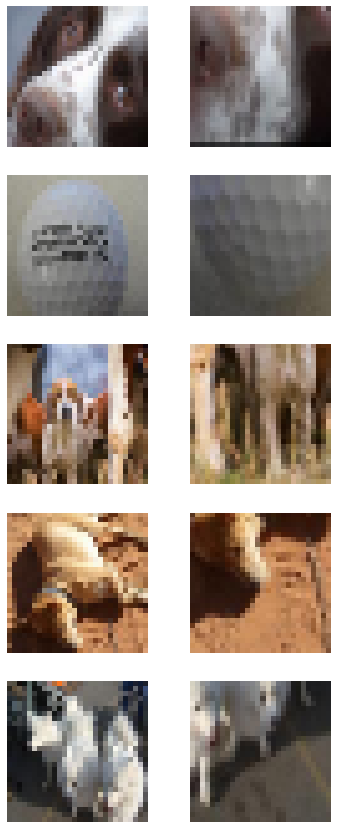

In [ ]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.sup_con.show(n=5)

In [ ]:
learn.fit(1)

In [ ]:
learn.recorder.losses

[TensorCategory(1.7556)]

In [ ]:
fastai_encoder = create_encoder('xresnet18', n_in=3, pretrained=False)
model = create_supcon_model(fastai_encoder, hidden_size=2048, projection_size=128)
aug_pipelines = get_supcon_aug_pipelines(size=28, rotate=False, jitter=False, bw=False, blur=False, stats=None, cuda=False)
learn = Learner(dls, model, cbs=[SupConMOCO(aug_pipelines, 
                                            unsup_class_id,
                                            unsup_method=UnsupMethod.All, K=25, reg_lambda=1.0, temp=0.07,
                                            print_augs=True),ShortEpochCallback(0.001)])

Pipeline: RandomResizedCrop -> RandomHorizontalFlip
Pipeline: RandomResizedCrop -> RandomHorizontalFlip


In [ ]:
learn.fit(1)

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01 - augmentations.ipynb.
Converted 02 - layers.ipynb.
Converted 03 - distributed.ipynb.
Converted 10 - simclr.ipynb.
Converted 11 - moco.ipynb.
Converted 12 - byol.ipynb.
Converted 13 - swav.ipynb.
Converted 14 - barlow_twins.ipynb.
Converted 15 - dino.ipynb.
Converted 16 - supcon.ipynb.
Converted 20 - clip.ipynb.
Converted 21 - clip-moco.ipynb.
Converted 70 - vision.metrics.ipynb.
Converted 90 - models.vision_transformer.ipynb.
Converted index.ipynb.
